## Проект: формирование модели монетизации в игре.

### Введение.

#### Задача: 
Сформировать модель монетизации игрового приложения.

#### Описание:
Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики. Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки. В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:
- победа над первым врагом;
- реализация проекта - разработка орбитальной сборки спутников;

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

#### Описание данных:

Таблица `game_actions.csv` - первые пользователи приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно:
- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Таблица `ad_cost.csv` - информация о рекламных активностях:
- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Таблица `user_source.csv` - информация о рекламных активностях:
- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение


<a id="table_of_contents"></a>
#### Содержание:
* [Шаг 1. Импорт библиотек и данных. Изучение общей информации. Предобработка данных.](#step_1)
    * [1.1. Таблица game_actions.](#step_1_1)
    * [1.2. Таблица ad_cost.](#step_1_2)
    * [1.3. Таблица user_source.](#step_1_3)
* [Шаг 1. Вывод.](#step_1_total)    
* [Шаг 2. Исследовательский анализ данных.](#step_2)
    * [2.1. Исследование стратегии игроков.](#step_2_1)
    * [2.2. Исследование времени, затраченного игроками на игру.](#step_2_2)
    * [2.3. Исследование построек игроков.](#step_2_3)
    * [2.4. Коэффициент удержания (Retention rate).](#step_2_4)
    * [2.5. Исследование источников рекламы.](#step_2_5)
* [Шаг 2. Вывод.](#step_2_total) 
* [Шаг 3. Проверка гипотез.](#step_3)
    * [3.1. Время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком различается.](#step_3_1)
    * [3.2. Количество построек у игроков, выбравших стратегию реализации проекта отличается от количества построек у игроков, выбравших стратегию победы над врагом.](#step_3_2)
* [Шаг 3. Вывод.](#step_3_total) 
* [Итог.](#step_total)
 

<a id="step_1"></a>
### Шаг 1. Импорт библиотек и данных. Изучение общей информации. Предобработка данных.
[К содержанию](#table_of_contents)

In [1]:
import pandas as pd
import datetime as dt

import numpy as np
import math as mth
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

import requests
from io import BytesIO

warnings.filterwarnings('ignore')  

In [2]:
# функция чтения данных из google sheets
def data_from_g_sheets(spreadsheet_id):
    file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
    r = requests.get(file_name)
    return pd.read_csv(BytesIO(r.content))

In [3]:
try:
    
    game_actions = pd.read_csv('/datasets/game_actions.csv')
    ad_cost = pd.read_csv('/datasets/ad_cost.csv')
    user_source = pd.read_csv('/datasets/user_source.csv')
    
except:
    
    game_actions = data_from_g_sheets('1bEUygQoiiTaNBXJEpr1oG0-n8c9PnhNHLzsZ_lYLAzM')
    ad_cost = data_from_g_sheets('1itqts3IDRitpk4hOaojsHh_jM7Mx6ZDyXYNxAhPwglM')
    user_source = data_from_g_sheets('1sV3EW4LsyMMbZc23EofA0AY6p2udbWIMdFMTzncSjOY')

<a id="step_1_1"></a>
#### Таблица `game_actions`:
[К содержанию](#table_of_contents)

In [4]:
display(game_actions.info())
display(game_actions.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


None

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


Пропуски в столбце `building_type`:

In [5]:
display(game_actions['building_type'].value_counts())
display(game_actions[game_actions['building_type'].isnull()]['event'].value_counts())

spaceport          59325
assembly_shop      54494
research_center    14138
Name: building_type, dtype: int64

finished_stage_1    5817
project             1866
Name: event, dtype: int64

В столбце `building_type` указывается один из трех видов текущей стройки игроком: `spaceport`, `assembly_shop` или `research_center`. Факт стройки отмечен статусом `building` в столбце `event`. Если у игрока статус `event` отличный от `building` - `finished_stage_1` или `project`, то это означает, что игрок в этот момент ничего не строит и в поле столбца `building_type` появляется пропуск. Оставляем как есть.

Пропуски в столбце `project_type`:

In [6]:
game_actions['project_type'].value_counts()

satellite_orbital_assembly    1866
Name: project_type, dtype: int64

В столбце `project_type` указывается тип реализованного проекта. Пропуски в этом столбце означают отсутсвие у игрока реализованного проекта. Оставляем как есть.

In [7]:
print('Количество дубликатов в таблице game_actions:', game_actions.duplicated().sum())

Количество дубликатов в таблице game_actions: 1


In [8]:
game_actions[game_actions.duplicated() == True]

,event_datetime,event,building_type,user_id,project_type
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


In [9]:
game_actions = game_actions.drop_duplicates()

Преобразование типа данных в слолбце `event_datetime` в datetime64:

In [10]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])

Добавление столбца `event_date` с датой:

In [11]:
game_actions['event_date'] = game_actions['event_datetime'].astype('datetime64[D]')

<a id="step_1_2"></a>
#### Таблица `ad_cost`:
[К содержанию](#table_of_contents)

In [12]:
display(ad_cost.info())
display(ad_cost.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


None

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


In [13]:
print('Количество дубликатов в таблице ad_cost:', ad_cost.duplicated().sum())

Количество дубликатов в таблице ad_cost: 0


Преобразование типа данных в слолбце `day` в datetime64:

In [14]:
ad_cost['day'] = pd.to_datetime(ad_cost['day'])
#ad_cost['day'] = ad_cost['day'].astype('datetime64[D]')

<a id="step_1_3"></a>
#### Таблица `user_source`:
[К содержанию](#table_of_contents)

In [15]:
display(user_source.info())
display(user_source.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


None

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


In [16]:
print('Количество дубликатов в таблице user_source:', user_source.duplicated().sum())

Количество дубликатов в таблице user_source: 0


<a id="step_1_total"></a>
### Шаг 1. Вывод.
[К содержанию](#table_of_contents)

В таблице `game_actions` отсутствие текущего строительства игроком, отмечено пропусками в столбце `building_type`.  В столбце `project_type` присутствуют пропуски, которые связаны с тем, что игрок еще не реализовал проект. Пропуски решено оставить. Так же в этой таблице обнаружен 1 дубликат, который был удален. В таблицах  `game_actions` и `ad_cost` столбцы с датой и временем были преобразованы в тип datetime64.

<a id="step_2"></a>
### Шаг 2. Исследовательский анализ данных.
[К содержанию](#table_of_contents)

<a id = "step_2_1"></a>
##### 2.1. Исследование стратегии игроков.
[К содержанию](#table_of_contents)

In [17]:
print('Данные о событиях игроков предоставлены с {:%d.%m.%Y} по {:%d.%m.%Y}'\
                      .format(game_actions['event_date'].min(), game_actions['event_date'].max()))

Данные о событиях игроков предоставлены с 04.05.2020 по 05.06.2020


Какие событие присутствуют в `event` таблицы `game_actions`:

In [18]:
game_actions['event'].value_counts()

building            127956
finished_stage_1      5817
project               1866
Name: event, dtype: int64

В соответствии с описанием датасета `game_actions`, игроки (`user_id`), имеющие признак `finished_stage_1` завершили первый уровень. Однако, в `game_actions` так же присутствуют игроки, имеющие признак `project` (реализация проекта), что в соответствии описанием так же является условием завершения игроком первого уровня. Проверим, есть ли игроки с `project` в `finished_stage_1`:

In [19]:
a = list(game_actions.query('event == "project"')['user_id'].unique())
b = list(game_actions.query('event == "finished_stage_1"')['user_id'].unique())
c = [e for e in a if e in b]
print('Количество уникальных игроков, имеющих одновременно признаки project и finished_stage_1: {:.0f}' .format(len(c)))

Количество уникальных игроков, имеющих одновременно признаки project и finished_stage_1: 1866


Игроки, одновременно имеющие признаки `project` и `finished_stage_1`, завершили первый уровень выполнив проект, остальные - победив врага.

Распределение игроков по достижениям:

In [20]:
builders_id = game_actions.query('project_type == "satellite_orbital_assembly"')['user_id'].to_list()
warriors_id = game_actions.query('(event == "finished_stage_1") and (user_id != @builders_id)')['user_id'].to_list()
winners_id = builders_id + warriors_id
andoned_id = list(game_actions.query('user_id != @winners_id')['user_id'].unique())
total_id = andoned_id + winners_id

print('Всего игроков: {:.0f}' .format(len(andoned_id) + len(winners_id)))
print('Всего игроков не достигших 1го уровня: {:.0f}' .format(len(andoned_id)),\
                    'или {:.0%} от общего числа игроков' .format(len(andoned_id) / (len(andoned_id) + len(winners_id))))
print('Всего игроков достигших 1го уровня: {:.0f}' .format(len(winners_id)),\
                    'или {:.0%} от общего числа игроков' .format(len(winners_id) / (len(andoned_id) + len(winners_id))))
print('Из них:')
print('- победивших врага: {:.0f}' .format(len(warriors_id)),\
                    'или {:.0%} от общего числа победителей' .format(len(warriors_id) / (len(winners_id))))
print('- реализуя проект: {:.0f}' .format(len(builders_id)),\
                    'или {:.0%} от общего числа победителей' .format(len(builders_id) / (len(winners_id))))

Всего игроков: 13576
Всего игроков не достигших 1го уровня: 7759 или 57% от общего числа игроков
Всего игроков достигших 1го уровня: 5817 или 43% от общего числа игроков
Из них:
- победивших врага: 3951 или 68% от общего числа победителей
- реализуя проект: 1866 или 32% от общего числа победителей


In [21]:
progress_visualization = pd.DataFrame({'progress': ['total_gamers', 'uncompleted_1_stage', 'completed_1_stage',],\
                                       'count': [len(total_id), len(andoned_id), len(winners_id)]})
stage_1_strategy_visualization = pd.DataFrame({'stage_1_strategy': ['total_completed', 'warriors_strategy', 'builders_strategy',],\
                                       'count': [len(winners_id), len(warriors_id), len(builders_id)]})

Распределение игроков по достижениям.

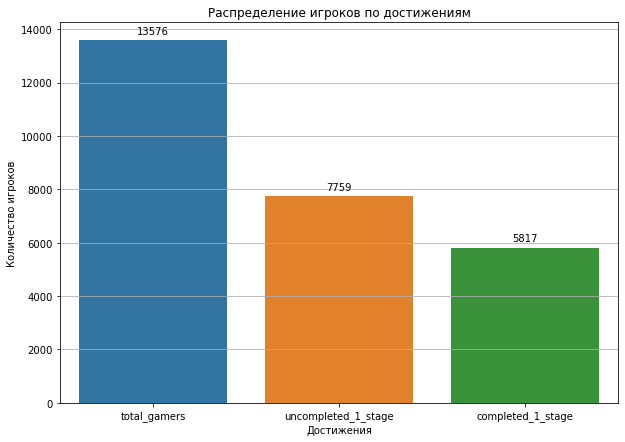

In [22]:
plt.figure(figsize=(10, 7))
plt.grid(True)
plt.title('Распределение игроков по достижениям')
#plot = sns.countplot(data = t, x = 'st')
#plot = sns.histplot(data = event_count, x = 'event', hue = 'st', multiple="dodge")
plot = sns.barplot(data = progress_visualization, x = 'progress', y = 'count')
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylabel('Количество игроков')
plt.xlabel('Достижения')
plt.xticks(rotation = 0)
plt.show()

Распределение игроков по выбранным стратегиям.

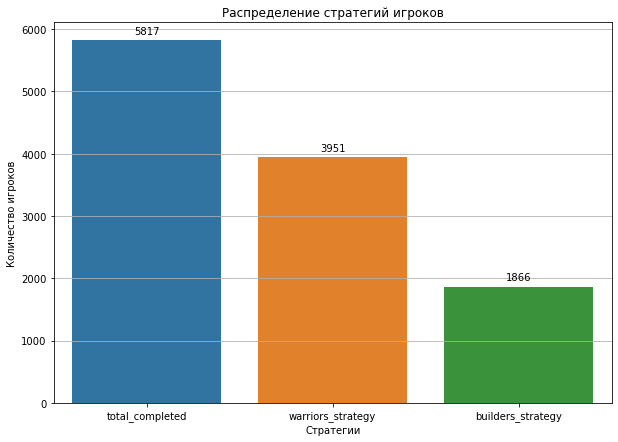

In [23]:
plt.figure(figsize=(10, 7))
plt.grid(True)
plt.title('Распределение стратегий игроков')
#plot = sns.countplot(data = t, x = 'st')
#plot = sns.histplot(data = event_count, x = 'event', hue = 'st', multiple="dodge")
plot = sns.barplot(data = stage_1_strategy_visualization, x = 'stage_1_strategy', y = 'count')
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylabel('Количество игроков')
plt.xlabel('Стратегии')
plt.xticks(rotation = 0)
plt.show()

Для достижения 1го уровня, игроки выбирают стратегию победы над врагом более чем в 2 раза чаще стратегии реализации проекта.

Присвоение каждому игроку (`user_id`) соответствующего статуса достижения.

In [24]:
def game_attainment(user):
    if user['user_id'] in andoned_id: 
        return 'uncompleted'
    if user['user_id'] in warriors_id:
        return 'warrior'
    if user['user_id'] in builders_id: 
        return 'builder'

In [25]:
game_actions['attainment'] = game_actions.apply(lambda x: game_attainment(x), axis = 1)

<a id = "step_2_2"></a>
##### 2.2. Исследование времени, затраченного игроками на игру.
[К содержанию](#table_of_contents)

DAU

In [26]:
print('В среднем, уникальных пользователей в день: {:.0F}' \
                      .format(game_actions.groupby('event_date')['user_id'].nunique().mean()))

В среднем, уникальных пользователей в день: 2885


Распределение уникальных пользователей в день, динамика

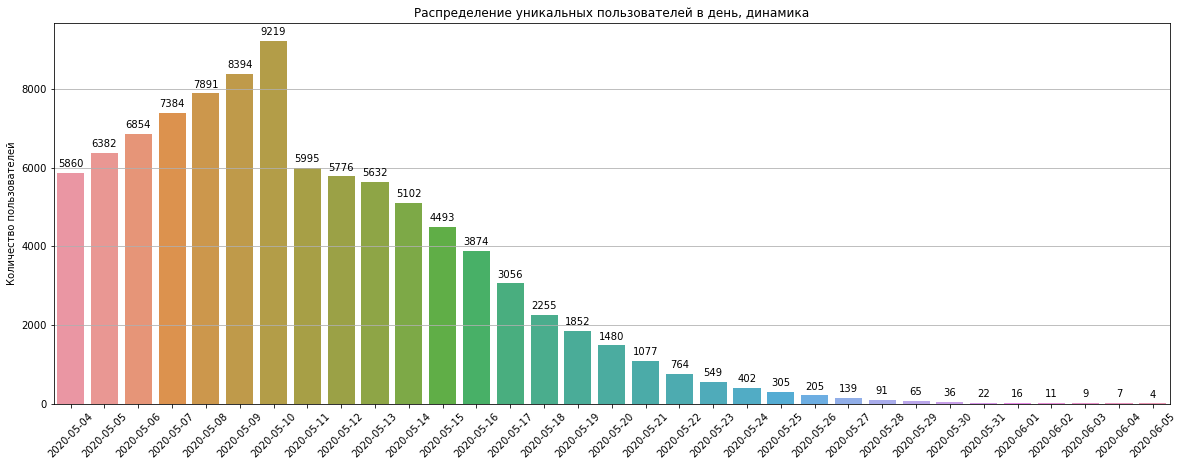

In [27]:
t = game_actions.groupby('event_date')['user_id'].nunique().reset_index()
t.index = t['event_date']

plt.figure(figsize=(20, 7))
plt.grid(True)
plt.title('Распределение уникальных пользователей в день, динамика')
#plot = sns.histplot(data = event_count, x = 'event', hue = 'st', multiple="dodge")
plot = sns.barplot(data = t, x = 'event_date', y = 'user_id')
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylabel('Количество пользователей')
plt.xlabel('')
plot.set_xticklabels(t.index.date, rotation = 45)
#plt.xticks(rotation = 45)
plt.show()

Пик количества уникальных пользователей пришелся на 10.05.2020.

Рассчет среднего времени проводимого игроком в игре.

In [28]:
date_min = game_actions.groupby('user_id')['event_datetime']\
                .min().reset_index().rename(columns = {'event_datetime' : 'min_date'})
date_max = game_actions.groupby('user_id')['event_datetime']\
                .max().reset_index().rename(columns = {'event_datetime' : 'max_date'})
date_min_max = pd.merge(date_min, date_max, how = 'left', on = 'user_id')
date_min_max['delta_days'] = (date_min_max['max_date'] - date_min_max['min_date']).astype('timedelta64[D]')

#time_table['delta_days'] = time_table['delta_date'].dt.days
#time_table['event_date'] = time_table['event_datetime'].dt.date

print('Игроки в среднем провели в игре:')
print('- не достигшие первого уровня: {:.0f} дней' \
                  .format(date_min_max.query('user_id == @andoned_id')['delta_days'].mean()))
print('- достигшие первого уровня победой над врагом: {:.0f} дней' \
                  .format(date_min_max.query('user_id == @warriors_id')['delta_days'].mean()))
print('- достигшие первого уровня реализовав проект: {:.0f} дней' \
                  .format(date_min_max.query('user_id == @builders_id')['delta_days'].mean()))

Игроки в среднем провели в игре:
- не достигшие первого уровня: 9 дней
- достигшие первого уровня победой над врагом: 11 дней
- достигшие первого уровня реализовав проект: 13 дней


<a id = "step_2_3"></a>
##### 2.3. Исследование построек игроков.
[К содержанию](#table_of_contents)

Общее количество построек в зависимости от достижения.

In [29]:
event_count = game_actions.query('(event != "project") and (event != "finished_stage_1")')\
                        .groupby(['user_id', 'attainment'])['event'].count().reset_index()

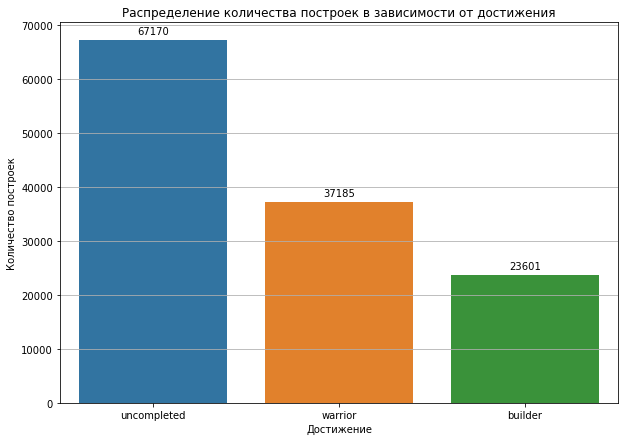

In [30]:
t = event_count.groupby('attainment')['event'].sum().reset_index().sort_values('event', ascending = False)

plt.figure(figsize=(10, 7))
plt.grid(True)
plt.title('Распределение количества построек в зависимости от достижения')
#plot = sns.countplot(data = t, x = 'st')
#plot = sns.histplot(data = event_count, x = 'event', hue = 'st', multiple="dodge")
plot = sns.barplot(data = t, x = 'attainment', y = 'event')
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylabel('Количество построек')
plt.xlabel('Достижение')
plt.xticks(rotation = 0)
plt.show()

Игроки, покинувшие игру, построили больше всего построек.

Количество построек в среднем на игрока в зависимости от достижения:

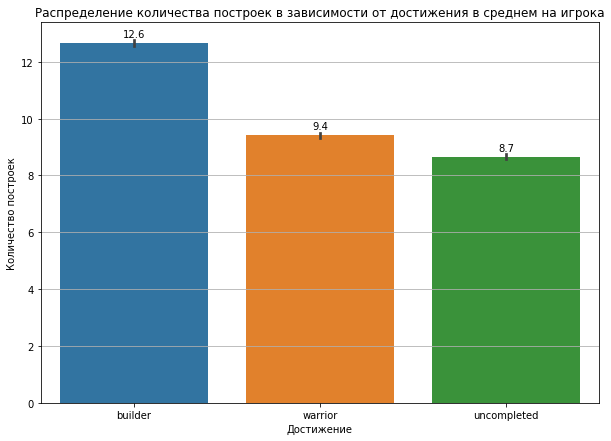

In [31]:
plt.figure(figsize=(10, 7))
plt.grid(True)
plt.title('Распределение количества построек в зависимости от достижения в среднем на игрока')
#plot = sns.countplot(data = t, x = 'st')
#plot = sns.histplot(data = event_count, x = 'event', hue = 'st', multiple="dodge")
plot = sns.barplot(data = event_count, x = 'attainment', y = 'event', order=['builder', 'warrior', 'uncompleted'])
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylabel('Количество построек')
plt.xlabel('Достижение')
plt.xticks(rotation = 0)
plt.show()

В среднем, игрок, выбравший стратегию реализации проекта, строит на 40% больше построек, чем игрок, выбравший стратегию победы над врагом, и чем игрок, оставивший игру.

Минимальное количество построек на игрока (сумма):

In [32]:
event_count.query('event == 1').count()

user_id       57
attainment    57
event         57
dtype: int64

Распределение количества построек по времени.

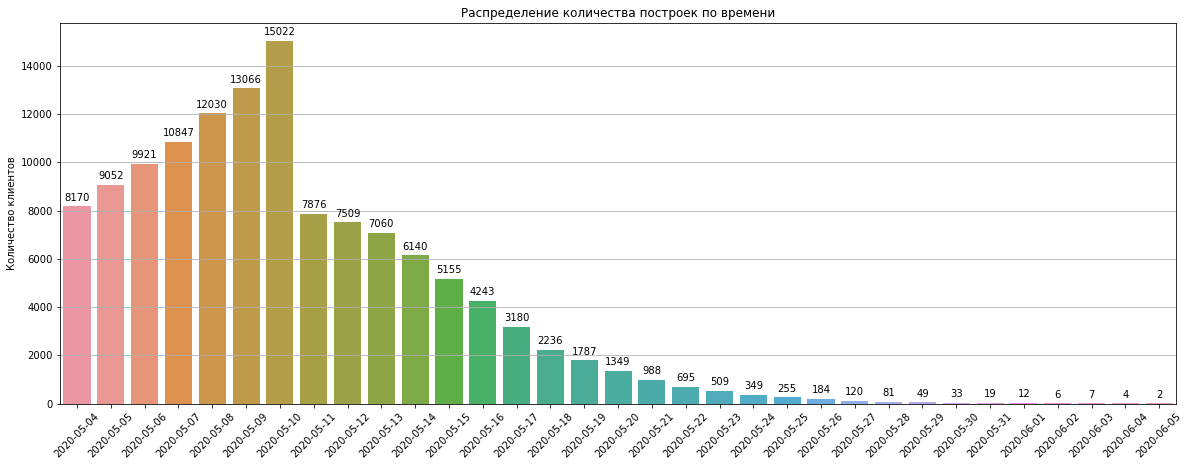

In [33]:
build_in_time = game_actions.query('(event != "project") and (event != "finished_stage_1")').reset_index()
t = build_in_time.groupby('event_date')['event'].count().reset_index().sort_values('event_date')
t.index = t['event_date']

plt.figure(figsize=(20, 7))
plt.grid(True)
plt.title('Распределение количества построек по времени')
plot = sns.countplot(data = build_in_time, x = 'event_date')
#plot = sns.histplot(data = event_count, x = 'event', hue = 'st', multiple="dodge")
#plot = sns.barplot(data = t, x = 'event_date', y = 'event')
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylabel('Количество клиентов')
plt.xlabel('')
plot.set_xticklabels(t.index.date, rotation = 45)
#plt.xticks(rotation = 45)
plt.show()

11 мая 2020 произошел резкий спад активности игроков. Возможно из - за окончания выходных, а возможно из - за окончания рекламной компании, которая проводилась:

In [34]:
print('с {:%d.%m.%Y} по {:%d.%m.%Y}'.format(ad_cost['day'].min(), ad_cost['day'].max()))

с 03.05.2020 по 09.05.2020


<a id = "step_2_4"></a>
##### 2.4. Коэффициент удержания (Retention rate).
[К содержанию](#table_of_contents)

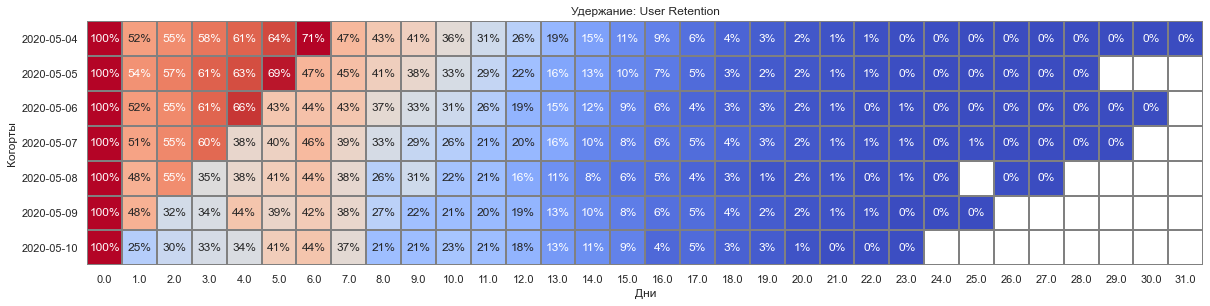

In [35]:
first_activity_date = game_actions.groupby('user_id')['event_datetime'].min()
first_activity_date.name = 'first_activity_date'
retention_rate = pd.merge(game_actions, first_activity_date, on = 'user_id')
retention_rate['first_session_day'] = retention_rate['first_activity_date'].astype('datetime64[D]')
retention_rate['session_day'] = retention_rate['event_datetime'].astype('datetime64[D]')
retention_rate['cohort_lifetime'] = retention_rate['session_day'] - retention_rate['first_session_day']
retention_rate['cohort_lifetime'] = retention_rate['cohort_lifetime'] / np.timedelta64(1, 'D')
retention_rate['cohort_lifetime'] = retention_rate['cohort_lifetime'].round()
cohorts = retention_rate.groupby(['first_session_day', 'cohort_lifetime']).agg({'user_id' : 'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_day', 'user_id']] 
initial_users_count = initial_users_count.rename(columns = {'user_id' : 'cohort_users'}) 
cohorts = pd.merge(cohorts, initial_users_count, on = 'first_session_day')
cohorts['retention'] = cohorts['user_id'] / cohorts['cohort_users'] 
retention_pivot = cohorts.pivot_table(index = 'first_session_day', 
                                      columns = 'cohort_lifetime', 
                                      values = 'retention', 
                                      aggfunc = 'sum')
sns.set(style = 'white')
plt.figure(figsize = (20, 15))
plt.title('Удержание: User Retention')
sns.heatmap(retention_pivot, annot = True, fmt = '.0%', 
            linewidths = 1, linecolor = 'gray', 
            cmap = 'coolwarm', vmin = 0, vmax = 0.7, square=True, cbar=0,
            yticklabels = retention_pivot.index.date)
plt.ylabel('Когорты')
plt.xlabel('Дни')
#plt.xticks(rotation = 45)
plt.show()


#retention_pivot

Практически для всех когорт в 1й день наблюдается удержание в 50%, а затем 5ти дневный прирост постоянных пользователь. Однако, уже на 15 день 90% игроков не возвращается. Стоить отметить, что это не совсем коэффициент удержания, так как игроки дополнительно уходят по причине окончания уровня.

<a id = "step_2_5"></a>
##### 2.5. Исследование источников рекламы.
[К содержанию](#table_of_contents)

In [36]:
print('Реклама проводилась с {:%d.%m.%Y} по {:%d.%m.%Y}'.format(ad_cost.day.min(), ad_cost.day.max()))

Реклама проводилась с 03.05.2020 по 09.05.2020


In [37]:
print('Всего на рекламу потратили: {:.0f}' .format(ad_cost['cost'].sum()))

Всего на рекламу потратили: 7604


Траты по источникам рекламы:

In [38]:
ad_cost.groupby('source')['cost'].sum().astype('int').reset_index().sort_values('cost', ascending = False)

,source,cost
2,yandex_direct,2233
1,instagram_new_adverts,2161
0,facebook_ads,2140
3,youtube_channel_reklama,1068


Количество привлеченных игроков в зависимости от источника.

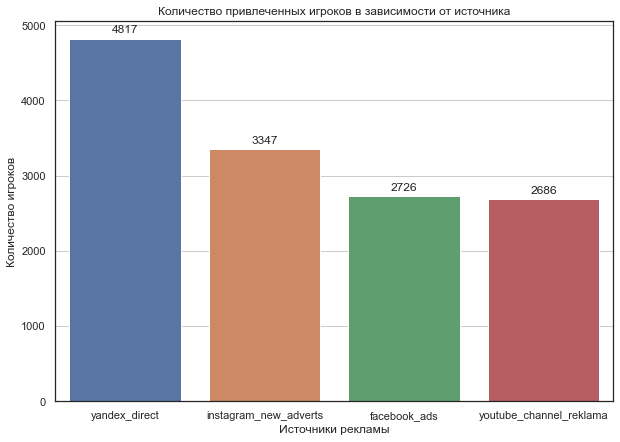

In [39]:
t = user_source.groupby('source')['user_id'].count().reset_index().sort_values('user_id', ascending = False)

plt.figure(figsize=(10, 7))
plt.grid(True)
plt.title('Количество привлеченных игроков в зависимости от источника')
#plot = sns.countplot(data = user_source, x = 'user_id', hue = 'source')
#plot = sns.histplot(data = event_count, x = 'event', hue = 'st', multiple="dodge")
plot = sns.barplot(data = t, x = 'source', y = 'user_id')
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylabel('Количество игроков')
plt.xlabel('Источники рекламы')
plt.xticks(rotation = 0)
plt.show()

Больше всего привлечено игроков из источника yandex_direct, меньше всего из youtube_channel_reklama

Стоимость привлечения одного клиента (CAC).

In [40]:
aa = ad_cost.groupby('source')['cost'].sum().astype('int').reset_index()
bb = user_source.groupby('source')['user_id'].count().reset_index().sort_values('user_id', ascending = False)
cac = pd.merge(aa, bb, on = 'source').rename(columns = {'user_id' : 'users_cnt'})
cac['cac'] = (cac['cost'] / cac['users_cnt']).round(2)
cac

,source,cost,users_cnt,cac
0,facebook_ads,2140,2726,0.79
1,instagram_new_adverts,2161,3347,0.65
2,yandex_direct,2233,4817,0.46
3,youtube_channel_reklama,1068,2686,0.40


In [41]:
print('Средняя стоимость привлечения одного клиента (независимо от источника): {:.2f} '\
                    .format(cac['cost'].sum() / cac['users_cnt'].sum()))

Средняя стоимость привлечения одного клиента (независимо от источника): 0.56 


Распределение дневных затрат на рекламу по источникам.

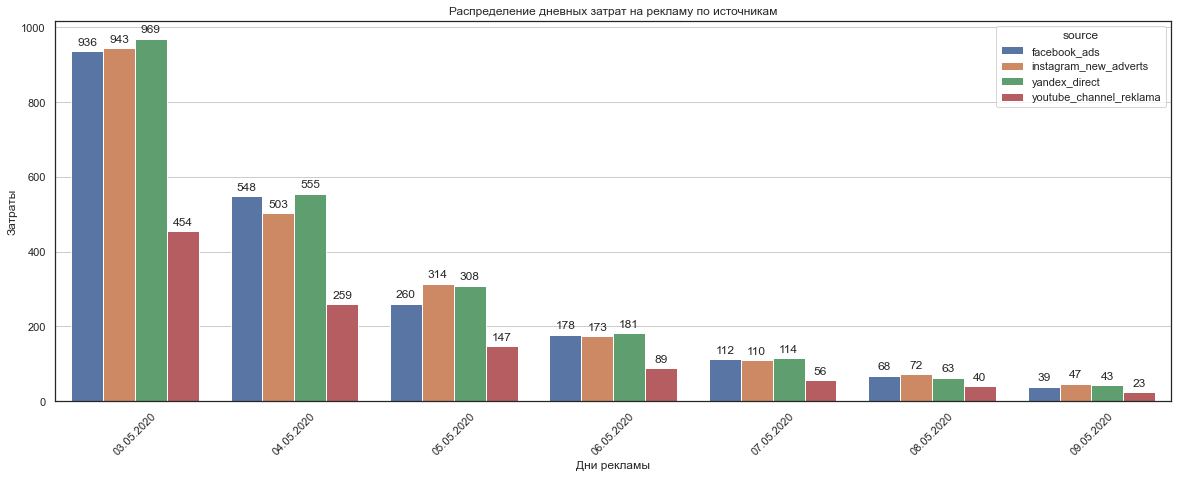

In [42]:
t = ad_cost.copy()
t.index = t['day']

plt.figure(figsize=(20, 7))
plt.grid(True)
plt.title('Распределение дневных затрат на рекламу по источникам')
#plot = sns.countplot(data = user_source, x = 'user_id', hue = 'source')
#plot = sns.histplot(data = event_count, x = 'event', hue = 'st', multiple="dodge")
plot = sns.barplot(data = t, x = t.index.strftime('%d.%m.%Y'), y = 'cost', hue = 'source')
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylabel('Затраты')
plt.xlabel('Дни рекламы')
#plot.set_xticklabels(tmp.index.date, rotation = 45)
plt.xticks(rotation = 45)
plt.show()

Исследование влияния источника рекламы на стратегию игроков.

In [43]:
strategy_per_sourse = pd.merge(game_actions, user_source, on = 'user_id')
strategy_per_sourse = strategy_per_sourse.groupby(['source', 'attainment'])['user_id'].nunique().reset_index()
strategy_per_sourse = pd.merge(strategy_per_sourse, cac[['source', 'users_cnt']], on = 'source') 
strategy_per_sourse['user_percent'] = ((strategy_per_sourse['user_id'] / strategy_per_sourse['users_cnt']) * 100).round(2)
strategy_per_sourse['user_percent_dev_100'] = (strategy_per_sourse['user_id'] / strategy_per_sourse['users_cnt']).round(2)

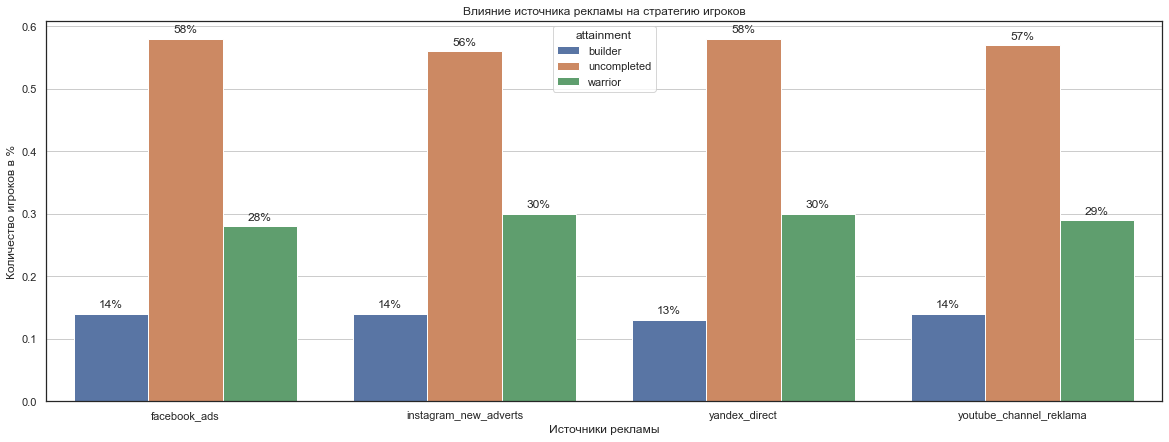

In [44]:
plt.figure(figsize=(20, 7))
plt.grid(True)
plt.title('Влияние источника рекламы на стратегию игроков')
#plot = sns.countplot(data = t, x = 'source', hue = 'attainment')
#plot = sns.histplot(data = event_count, x = 'event', hue = 'st', multiple="dodge")
plot = sns.barplot(data = strategy_per_sourse, x = 'source', y = 'user_percent_dev_100', hue = 'attainment')
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0%'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylabel('Количество игроков в %')
plt.xlabel('Источники рекламы')
#plot.set_xticklabels(t.index.date, rotation = 45)
#plt.xticks(rotation = 0)
plt.show()

Разница в поведении игроков в зависимости от источника рекламы - отсутствует.

<a id="step_2_total"></a>
### Шаг 2. Вывод.
[К содержанию](#table_of_contents)

Данные о событиях игроков предоставлены с 04.05.2020 по 05.06.2020

Всего игроков: 13576, их них:
- не достигших 1го уровня: 7759 или 57% от общего числа игроков
- достигших 1го уровня: 5817 или 43% от общего числа игроков
- победивших врага: 3951 или 68% от общего числа победителей
- реализовавших проект: 1866 или 32% от общего числа победителей

Для достижения 1го уровня, игроки выбирают стратегию победы над врагом более чем в 2 раза чаще стратегии реализации проекта.

- В среднем, уникальных пользоваелей в день: 2885
- Пик количества уникальных пользователей пришелся на 10.05.2020.

Игроки, в среднем, провели в игре:
- не достигшие первого уровня: 9 дней
- достигшие первого уровня победой над врагом: 11 дней
- достигшие первого уровня реализовав проект: 13 дней

Игроки, покинувшие игру, построили больше всего построек.

В среднем, игрок, выбравший стратегию реализации проекта, строит на 40% больше построек, чем игрок, выбравший стратегию победы над врагом, и чем игрок, оставивший игру.

11 мая 2020 произошел резкий спад активности игроков. Возможно из - за окончания выходных, а возможно из - за окончания рекламной компании, которая проводилась:

Практически для всех когорт в 1й день наблюдается удержание в 50%, а затем 5ти дневный прирост постоянных пользователь. Однако, уже на 15 день 90% игроков не возвращается.

Реклама проводилась с 03.05.2020 по 09.05.2020

- Всего на рекламу потратили: 7604

Затраты на рекламу по источникам:
- yandex_direct: 2233 
- instagram_new_adverts: 2161
- facebook_ads: 2140
- youtube_channel_reklama: 1068

Больше всего привлечено игроков из источника yandex_direct - 4817, меньше всего из youtube_channel_reklama - 1068

Стоимость привлечения одного игрока:
- facebook_ads: 0.79
- instagram_new_adverts: 0.65
- yandex_direct: 0.46
- youtube_channel_reklama: 0.40

Разница в поведении игроков в зависимости от источника рекламы - отсутствует.




<a id="step_3"></a>
### Шаг 3. Проверка гипотез.
[К содержанию](#table_of_contents)

<a id = "step_3_1"></a>
##### 3.1. Время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком различается.
[К содержанию](#table_of_contents)

- H0 = Время прохождения уровня между игроками не различается
- H1 = Время прохождения уровня между игроками различается

In [45]:
builders_time = date_min_max.query('user_id == @builders_id')
warriors_time = date_min_max.query('user_id == @warriors_id')

In [46]:
alpha = 0.05

results = st.ttest_ind(warriors_time['delta_days'], builders_time['delta_days'])
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу, время прохождения уровня между игроками различается")
else:
    print("Не получилось отвергнуть нулевую гипотезу, время прохождения уровня между игроками не различается")
print('\n')
print('в среднем: {:.0f} дней при победе над врагом и {:.0f} дней при реализации проекта' \
                  .format(date_min_max.query('user_id == @warriors_id')['delta_days'].mean(), \
                          date_min_max.query('user_id == @builders_id')['delta_days'].mean()))

p-значение:  1.8882835392369192e-97
Отвергаем нулевую гипотезу, время прохождения уровня между игроками различается


в среднем: 11 дней при победе над врагом и 13 дней при реализации проекта


<a id = "step_3_2"></a>
##### 3.2. Количество построек у игроков, выбравших стратегию реализации проекта отличается от количества построек у игроков, выбравших стратегию победы над врагом.
[К содержанию](#table_of_contents)

- H0 = Количество построек у игроков не различается
- H1 = Количество построек у игроков различается

In [47]:
builders_buildings = event_count.query('user_id == @builders_id')
warriors_buildings = event_count.query('user_id == @warriors_id')

In [48]:
alpha = 0.05

results = st.ttest_ind(builders_buildings['event'], warriors_buildings['event'])
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу, количество построек у игроков различается")
else:
    print("Не получилось отвергнуть нулевую гипотезу, количество построек у игроков не различается")
print('\n')
print('в среднем: {:.0f} построек у игрока, победившего врага и {:.0f} построек у игрока, реализовавшего проект' \
                  .format(round(event_count.query('attainment == "warrior"')['event'].mean(), 1), \
                          round(event_count.query('attainment == "builder"')['event'].mean(), 1)))

p-значение:  0.0
Отвергаем нулевую гипотезу, количество построек у игроков различается


в среднем: 9 построек у игрока, победившего врага и 13 построек у игрока, реализовавшего проект


<a id="step_3_total"></a>
### Шаг 3. Вывод.
[К содержанию](#table_of_contents)

Гипотеза подтверждается:
- Время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком различается.

Гипотеза подтверждается:
- Количество построек у игроков, выбравших стратегию реализации проекта отличается от количества построек у игроков, выбравших стратегию победы над врагом.

<a id="step_total"></a>
### Итог.
[К содержанию](#table_of_contents)

#### В целом по игре.

Так как реклама планируется к показу на экране выбора постойки, то игроки, выбравшие стратегию реализации проекта будут предпочтительнее игроков победивших врага. Среднее число постороек у первых - 13, у вторых - 9. Среднее время проведенное в игре у первых - 13 дней, у вторых - 11 дней. Соответственно, игроки, реализующие проект больше всех смогут посмотреть рекламы. 



#### Предлагаемая модель монетизации.


Площадки для рекламы:

В порядке приоритета:
- yandex_direct
- youtube_channel_reklama
- instagram_new_adverts
- facebook_ads

Для окупаемости затрат на привлечение клиента, стоимость рекламы должна быть следующая:

 - При однократном показе рекламы игроку на экране выбора постройки: 
      - минимум 0.79 за показ - если источник игрока facebook_ads
      - минимум 0.65 за показ - если источник игрока instagram_new_adverts
      - минимум 0.46 за показ - если источник игрока yandex_direct
      - минимум 0.40 за показ - если источник игрока youtube_channel_reklama
      
При выборе такого сценария, необходимо начать показ рекламы с первого же экрана выбора посторйки, так как минимум 57 игроков совершили только 1 постройку.   
      
 - При показе рекламы игроку на каждом экране выбора постройки (из рассчета, что средний игрок строит 9,4 постройки):
      - минимум 0.084 за показ - если источник игрока facebook_ads
      - минимум 0.069 за показ - если источник игрока instagram_new_adverts
      - минимум 0.049 за показ - если источник игрока yandex_direct
      - минимум 0.043 за показ - если источник игрока youtube_channel_reklama
      
При втором варианте, необходимо соблюдать баланс в сторону увеличения стоимости показа и уменьшения их количества, так как слишком частая реклама может разозлить игрока и он уйдет.


#### В качестве рекомендации: 

Cтоит сбалансировать сценарий победы над врагом для достижения первого уровня, такую стратегию выбрало большее количество игроков, но это негативно сказалось на количестве построек и, как следствие, возможности показа рекламы таким игрокам. Так же стоит проработать вопрос по увеличению коэффициента удержания пользователя (Retention rate). Для привлечения нового клиента, необходимы немалые затраты на маркетинг, в то время как затраты для удержания клиентов минимальны.

Так же стоит рассмотреть и другие модели монетизации, к примеру:

- Покупная версия
- Freemium — условно-бесплатная модель с ограниченным доступом
- Free-to-Play — условно-бесплатная модель с внутриигровыми покупками
- Pay-to-play — игра по подписке


[Презентация](https://drive.google.com/file/d/1xBzDkc1Mg3y5SdrEozaVHgIzfGoWO5HX/view?usp=sharing)

[Дашборд](https://public.tableau.com/profile/igor4051#!/vizhome/spacebrothers/spacebrothers?publish=yes)